In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

In [3]:
DATASET_PATH = "/kaggle/input/monkeypox-skin-lesion-dataset/Original Images/Original Images"  

def explore_dataset(path):
    for root, dirs, files in os.walk(path):
        print(f"Directory: {root}, Number of files: {len(files)}")

In [4]:
explore_dataset(DATASET_PATH)

Directory: /kaggle/input/monkeypox-skin-lesion-dataset/Original Images/Original Images, Number of files: 0
Directory: /kaggle/input/monkeypox-skin-lesion-dataset/Original Images/Original Images/Others, Number of files: 126
Directory: /kaggle/input/monkeypox-skin-lesion-dataset/Original Images/Original Images/Monkey Pox, Number of files: 102


In [5]:
def get_class_distribution(path):
    class_counts = {}
    for class_name in os.listdir(path):
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

class_distribution = get_class_distribution(DATASET_PATH)
print(f"Class distribution: {class_distribution}")

Class distribution: {'Others': 126, 'Monkey Pox': 102}


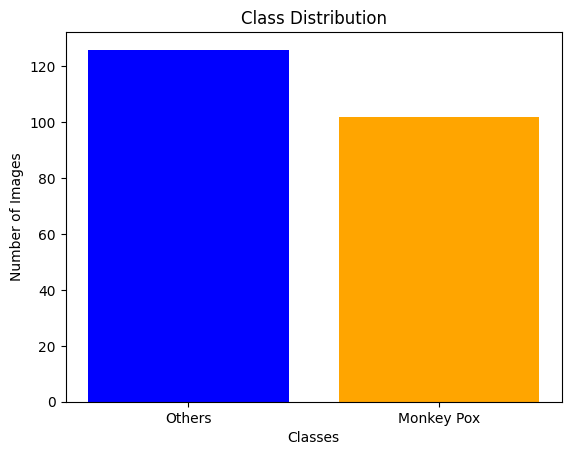

In [6]:
def plot_class_distribution(class_counts):
    plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'orange'])
    plt.title('Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.show()

plot_class_distribution(class_distribution)

In [7]:
image_folder = "/kaggle/input/monkeypox-skin-lesion-dataset/Original Images/Original Images/Monkey Pox"

images = []
for filename in os.listdir(image_folder):
    if filename.endswith((".jpg")):  # Check for valid image files
        img_path = os.path.join(image_folder, filename)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))  # Resize images
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        images.append(img_array)

images = np.array(images)

images_normalized = images / 255.0

data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_images = [data_gen.random_transform(img) for img in images_normalized]

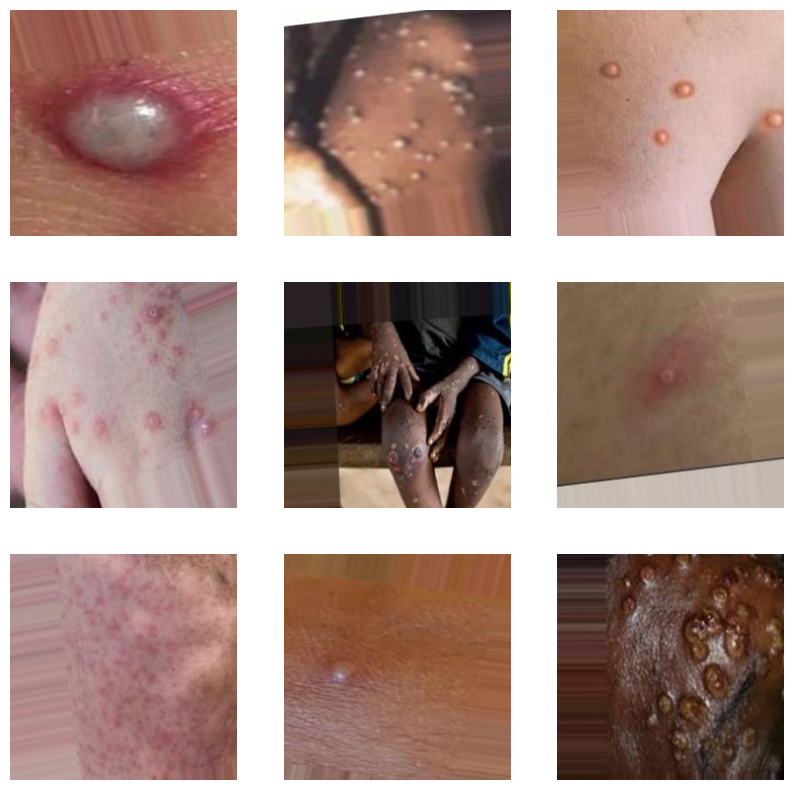

In [8]:
plt.figure(figsize=(10, 10))
for i in range(9):  # Display 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()

Shape of features after selection: (228, 50)

Evaluating KNN...
Cross-validation Accuracy Scores: [0.75675676 0.78378378 0.75       0.77777778 0.69444444]
Mean Accuracy: 0.7526
Confusion Matrix for KNN:
[[13  8]
 [ 3 22]]

Evaluating SVM...
Cross-validation Accuracy Scores: [0.91891892 0.86486486 0.77777778 0.94444444 0.83333333]
Mean Accuracy: 0.8679
Confusion Matrix for SVM:
[[15  6]
 [ 2 23]]

Evaluating Random Forest...
Cross-validation Accuracy Scores: [0.67567568 0.78378378 0.66666667 0.75       0.72222222]
Mean Accuracy: 0.7197
Confusion Matrix for Random Forest:
[[15  6]
 [ 6 19]]


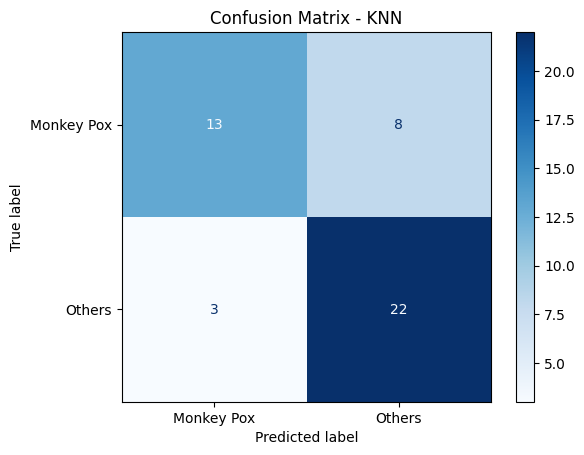

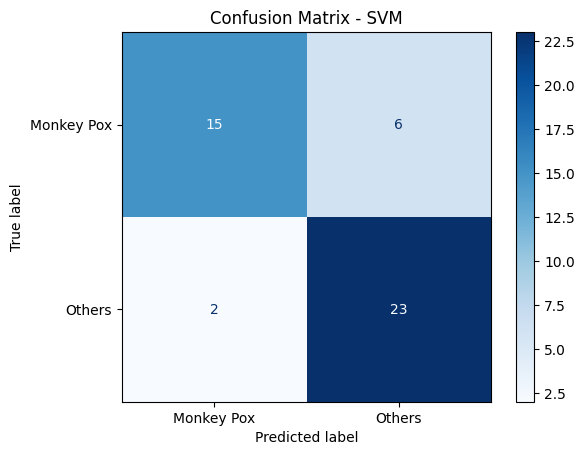

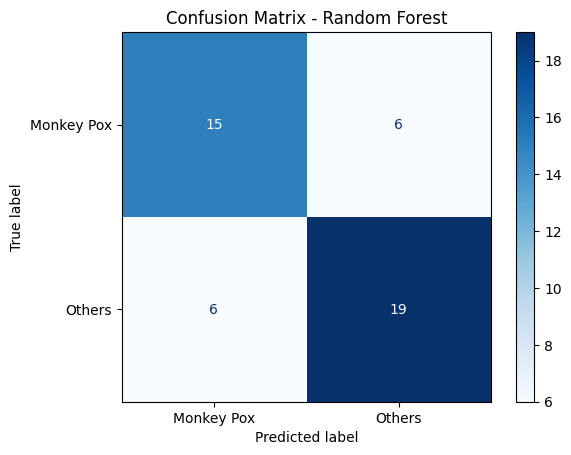

In [9]:
import os
import numpy as np
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, f_classif
import tensorflow as tf

def load_images_and_labels(base_path):
    images = []
    labels = []
    for label, folder_name in enumerate(["Monkey Pox", "Others"]):  # Assign 0 to "Monkey Pox" and 1 to "Others"
        folder_path = os.path.join(base_path, folder_name)
        for filename in os.listdir(folder_path):
            if filename.endswith((".jpg", ".png", ".jpeg")):  # Valid image file extensions
                img_path = os.path.join(folder_path, filename)
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))  # Resize to 224x224
                img_array = tf.keras.preprocessing.image.img_to_array(img)  # Convert to NumPy array
                images.append(img_array)
                labels.append(label)
    return np.array(images), np.array(labels)
DATASET_PATH = "/kaggle/input/monkeypox-skin-lesion-dataset/Original Images/Original Images"  
images, labels = load_images_and_labels(DATASET_PATH)

images_normalized = images / 255.0

images_normalized, labels = shuffle(images_normalized, labels, random_state=42)

def extract_hog_features(images):
    hog_features = []
    for image in images:
        # Convert to grayscale as HOG works on single-channel images
        gray_image = rgb2gray(image)
        # Extract HOG features
        features = hog(
            gray_image,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm='L2-Hys',
            visualize=False
        )
        hog_features.append(features)
    return np.array(hog_features)

# Extract HOG features
X = extract_hog_features(images_normalized)
y = labels

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Feature selection using Fisher Score 
selector = SelectKBest(score_func=f_classif, k=50)  # Select top 50 features
X_selected = selector.fit_transform(X_scaled, y)
print("Shape of features after selection:", X_selected.shape)

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define machine learning models
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(kernel='linear', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Train and evaluate each model using cross-validation
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")
    cv_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    print(f"Cross-validation Accuracy Scores: {cv_scores}")
    print(f"Mean Accuracy: {np.mean(cv_scores):.4f}")

    # Train the model and plot confusion matrix
    model.fit(X_train, y_train) 
    y_pred = model.predict(X_test)  

    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix for {model_name}:\n{cm}")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Monkey Pox", "Others"])
    disp.plot(cmap="Blues")
    disp.ax_.set_title(f"Confusion Matrix - {model_name}")
